## Question 4 : Referring Image Segmentation (RIS)

### Part 1

In [1]:
!git clone https://github.com/yz93/LAVT-RIS.git
!pip install h5py
!pip install timm
!pip install mmcv==1.3.12
!pip install mmsegmentation==0.17.0
!pip install -r /kaggle/working/LAVT-RIS/requirements.txt

Cloning into 'LAVT-RIS'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 131 (delta 15), reused 12 (delta 12), pack-reused 107 (from 1)
Receiving objects: 100% (131/131), 6.92 MiB | 31.33 MiB/s, done.
Resolving deltas: 100% (28/28), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 29.4 MB/s eta 0:00:00:00:0100:01
  Attempting unins

In [2]:
!gdown 13D-OeEOijV8KTC3BkFP-gOJymc6DLwVT

Downloading...
From (original): https://drive.google.com/uc?id=13D-OeEOijV8KTC3BkFP-gOJymc6DLwVT
From (redirected): https://drive.google.com/uc?id=13D-OeEOijV8KTC3BkFP-gOJymc6DLwVT&confirm=t&uuid=b8649fd7-00f8-4695-b79b-d125a7e8a36e
To: /kaggle/working/refcoco.pth
100%|███████████████████████████████████████| 2.42G/2.42G [00:19<00:00, 124MB/s]


In [5]:
weights = "refcoco.pth" 

import os
import sys
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as T
import torch.nn.functional as F
import matplotlib.pyplot as plt

sys.path.append("/kaggle/working/LAVT-RIS")

from lib import segmentation 
from bert.tokenization_bert import BertTokenizer
from bert.modeling_bert import BertModel
from scipy.ndimage.morphology import binary_dilation

device = "cuda:0" if torch.cuda.is_available() else "cpu"

class Args: 
    swin_type="base"
    window12=True
    mha=""
    fusion_drop=0.0

model_segm = segmentation.__dict__['lavt'](pretrained="", args=Args())
bert_model = BertModel.from_pretrained("bert-base-uncased")
bert_model.pooler = None

ckpt = torch.load(weights, map_location="cpu")
bert_model.load_state_dict(ckpt['bert_model'])
model_segm.load_state_dict(ckpt['model'])

/tmp/ipykernel_31/1160163953.py:17: DeprecationWarning: Please import `binary_dilation` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.morphology import binary_dilation
/usr/local/lib/python3.11/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Window size 12!
Randomly initialize Multi-modal Swin Transformer weights.


Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

/kaggle/working/LAVT-RIS/bert/modeling_utils.py:676: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(resolved_archive_file, map_location="cpu")
/tmp/ip

<All keys matched successfully>

### Part 2

In [6]:
images_data = {}
with open("/kaggle/input/cv-hw3-q4/reference.txt", 'r') as file:
    for line in file:
        image_name, text = line.split(':', 1)
        image_name = image_name.strip()
        text = text.strip()
        text = text.strip('""')
        images_data[image_name] = text
print(images_data)

{'ILSVRC2012_test_00000003.jpg': 'The walking dog in the picture', 'ILSVRC2012_test_00000004.jpg': 'The smiling dog in the grass', 'ILSVRC2012_test_00000018.jpg': 'The boy on left smiling and holding icecream', 'ILSVRC2012_test_00000019.jpg': 'The black gray bird on in the picture', 'ILSVRC2012_test_00000022.jpg': 'The sad dog standing beside the pool', 'ILSVRC2012_test_00000023.jpg': 'The guy in white shirt on the bicycle', 'ILSVRC2012_test_00000025.jpg': 'The butterfly in the picture', 'ILSVRC2012_test_00000026.jpg': 'The mang wearing a suite and tie', 'ILSVRC2012_test_00000030.jpg': 'The duck in the picture', 'ILSVRC2012_test_00000034.jpg': 'The white coffee cups on the coffee machine'}


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

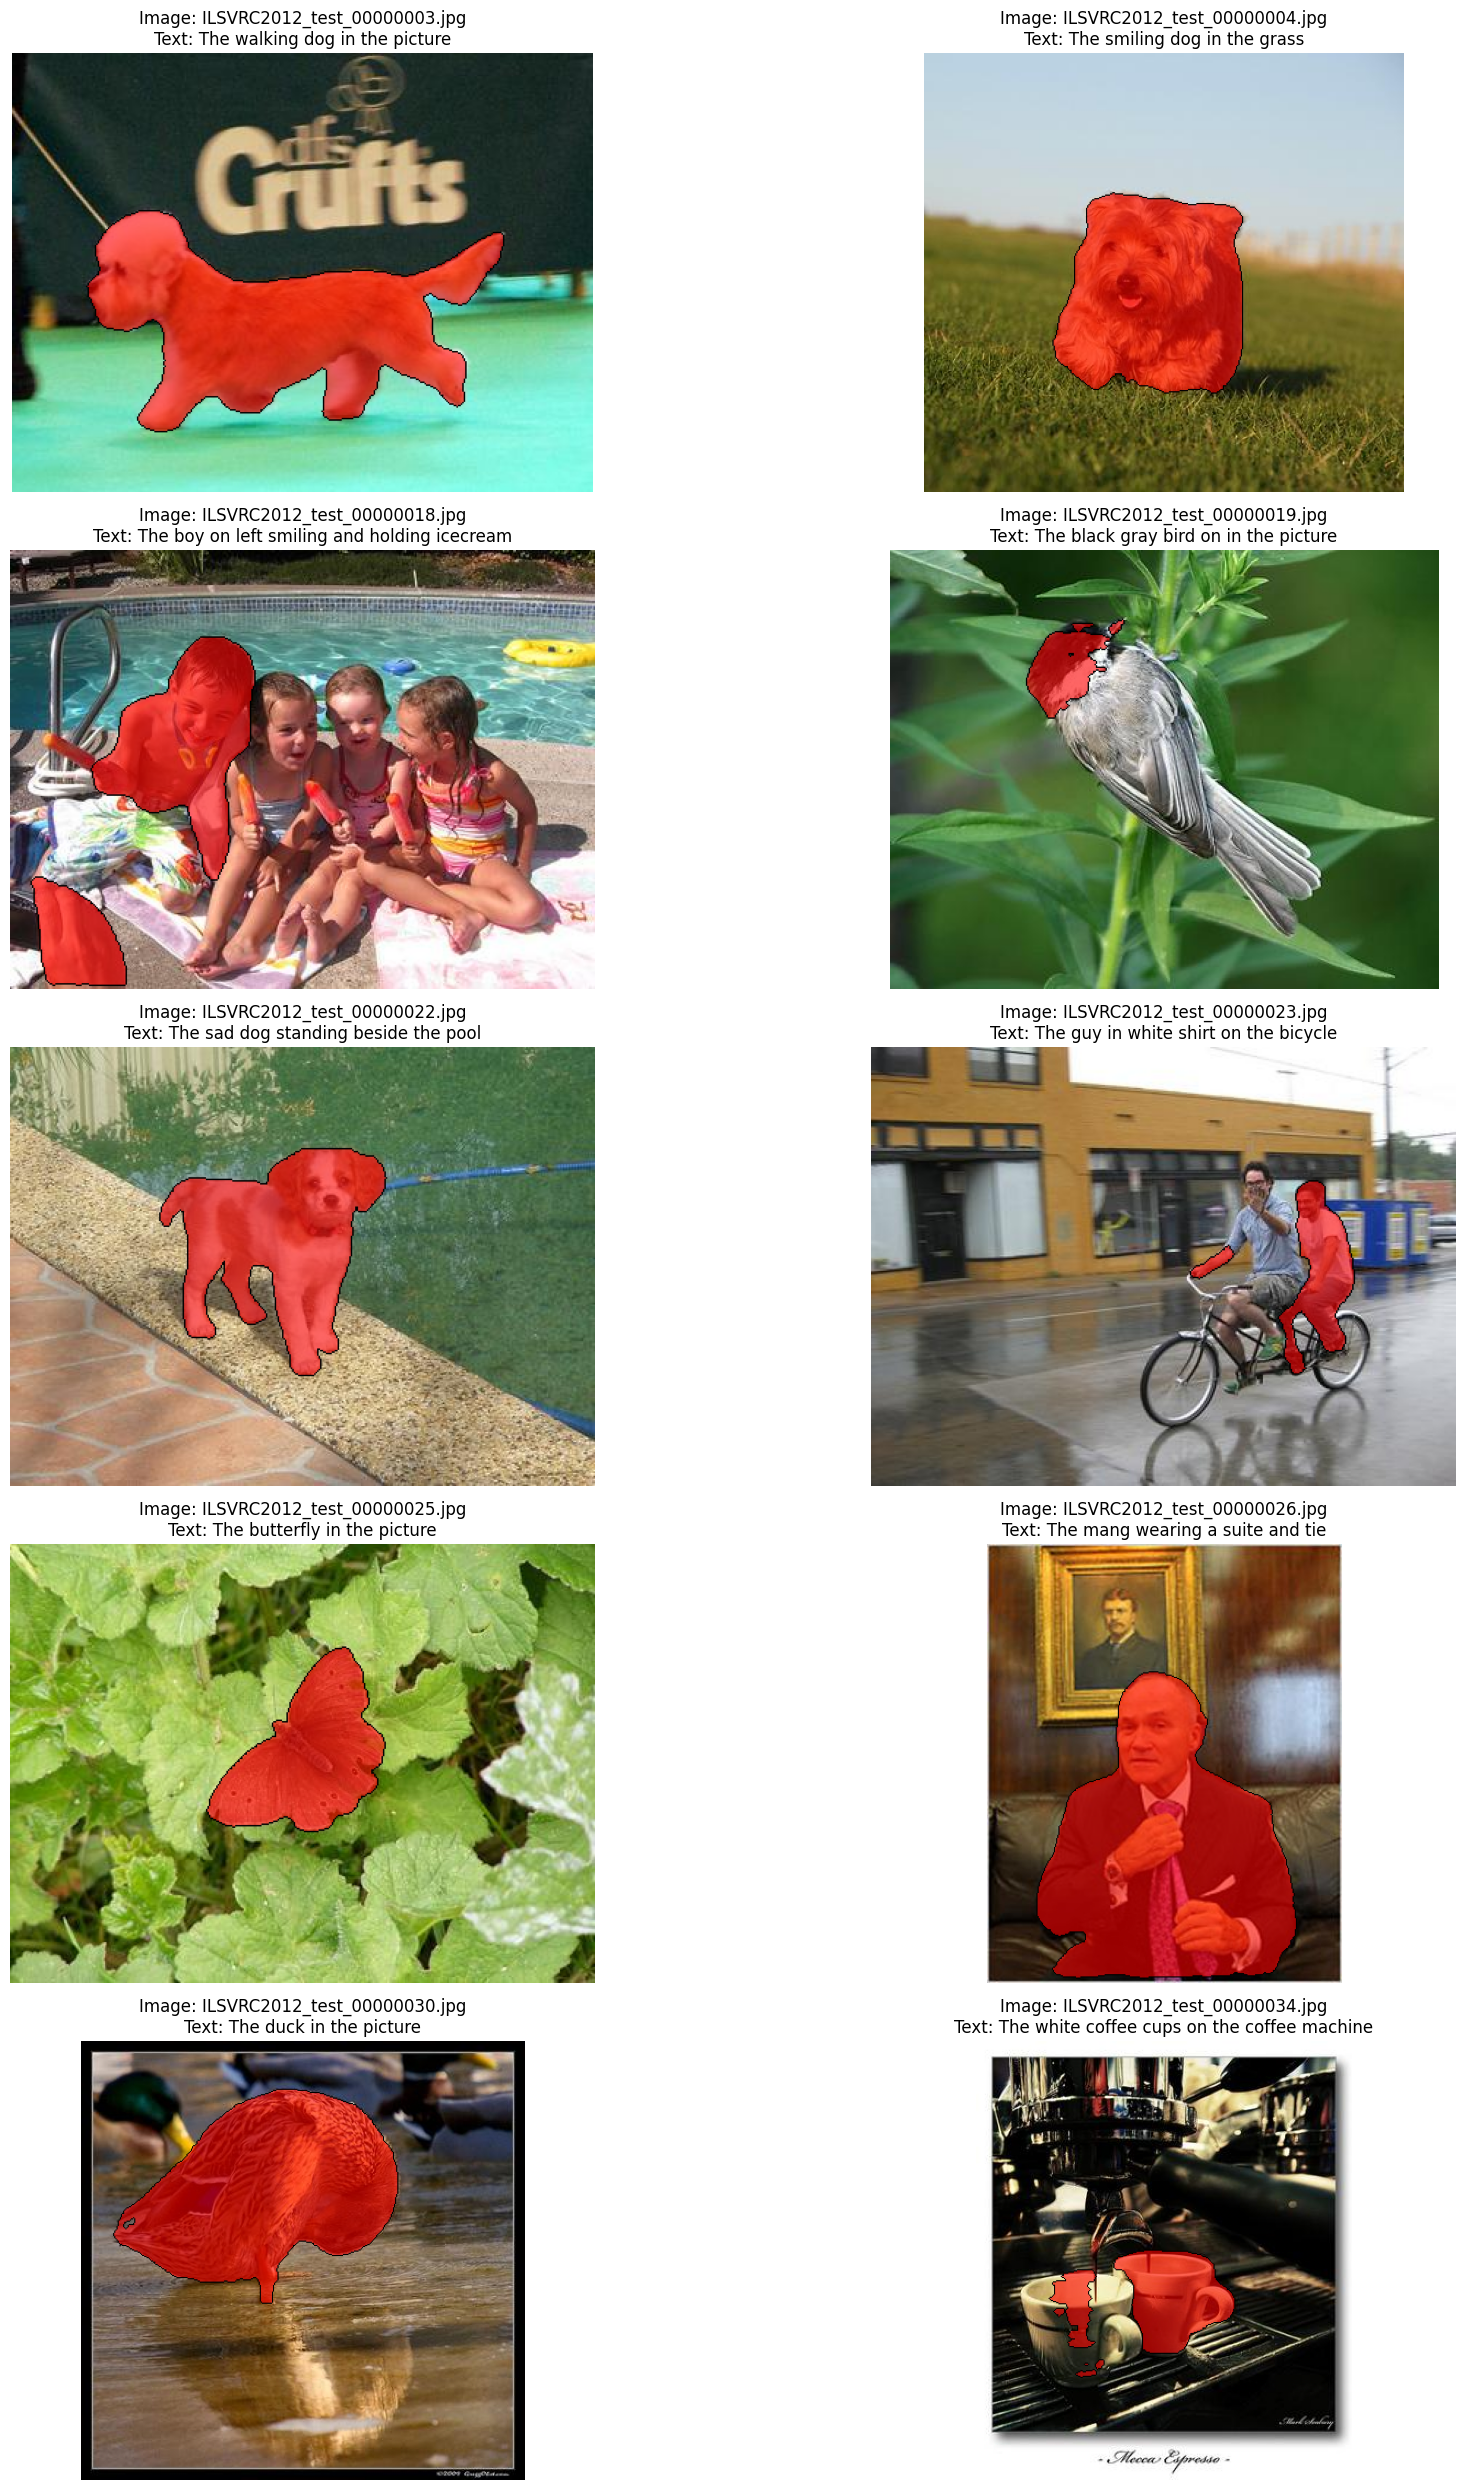

In [7]:
model_segm.to(device).eval()
bert_model.to(device).eval()

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

transform = T.Compose([
    T.Resize(480),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

def overlay_davis(image, mask, colors=[[0, 0, 0], [255, 0, 0]], cscale=1, alpha=0.4):
    colors = np.reshape(colors, (-1, 3))
    colors = np.atleast_2d(colors) * cscale

    im_overlay = image.copy()
    object_ids = np.unique(mask)

    for object_id in object_ids[1:]:
        foreground = image*alpha + np.ones(image.shape)*(1-alpha) * np.array(colors[object_id])
        binary_mask = mask == object_id

        im_overlay[binary_mask] = foreground[binary_mask]

        countours = binary_dilation(binary_mask) ^ binary_mask
        im_overlay[countours, :] = 0

    return im_overlay.astype(image.dtype)

plt.figure(figsize=(20, 25))

for idx, (image_name, text) in enumerate(images_data.items()):
    image_path = f"/kaggle/input/cv-hw3-q4/samples/{image_name}"
    
    img_pil = Image.open(image_path).convert("RGB")
    orig_w, orig_h = img_pil.size
    img_np = np.array(img_pil)
    
    img_tensor = transform(img_pil).unsqueeze(0).to(device)  
    
    tokens = tokenizer.encode(text, add_special_tokens=True)[:20]
    padded_sent_toks = [0] * 20
    padded_sent_toks[:len(tokens)] = tokens
    
    attention_mask = [0] * 20
    attention_mask[:len(tokens)] = [1] * len(tokens)
    
    input_ids = torch.tensor(padded_sent_toks).unsqueeze(0).to(device)  
    attn_mask = torch.tensor(attention_mask).unsqueeze(0).to(device)  
    
    with torch.no_grad():
        last_states = bert_model(input_ids, attention_mask=attn_mask)[0]
        embedding = last_states.permute(0,2,1)
        output = model_segm(img_tensor, embedding, l_mask=attn_mask.unsqueeze(2))
        output = output.argmax(dim=1, keepdim=True).float()
        output = F.interpolate(output, (orig_h, orig_w), mode="nearest").squeeze().cpu().numpy()
    
    output = output.astype(np.uint8)
    visualization = overlay_davis(img_np, output)
    
    plt.subplot(5, 2, idx+1)
    plt.imshow(visualization)
    plt.title(f"Image: {image_name}\nText: {text}")
    plt.axis('off')

plt.tight_layout()
plt.show()

### Part 3

In [8]:
print(model_segm)

LAVT(
  (backbone): MultiModalSwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): MMBasicLayer(
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=128, out_features=384, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=128, out_features=128, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=128, out_featur

### Part 4

In [9]:
images_data = {}
with open("/kaggle/input/cv-hw3-q4/my_reference.txt", 'r') as file:
    for line in file:
        image_name, text = line.split(':', 1)
        image_name = image_name.strip()
        text = text.strip()
        text = text.strip('""')
        images_data[image_name] = text
print(images_data)

{'ILSVRC2012_test_00000003.jpg': 'dog walking to left', 'ILSVRC2012_test_00000004.jpg': 'dog in the park', 'ILSVRC2012_test_00000018.jpg': 'leftmost boy in the group', 'ILSVRC2012_test_00000019.jpg': 'bird sitting on a branch', 'ILSVRC2012_test_00000022.jpg': 'dog standing beside the water', 'ILSVRC2012_test_00000023.jpg': 'The man sitting behind on the bicyle', 'ILSVRC2012_test_00000025.jpg': 'butterfly on the leaves', 'ILSVRC2012_test_00000026.jpg': 'A man adjusting his tie', 'ILSVRC2012_test_00000030.jpg': 'A bird standing in water', 'ILSVRC2012_test_00000034.jpg': '2 coffee cups'}


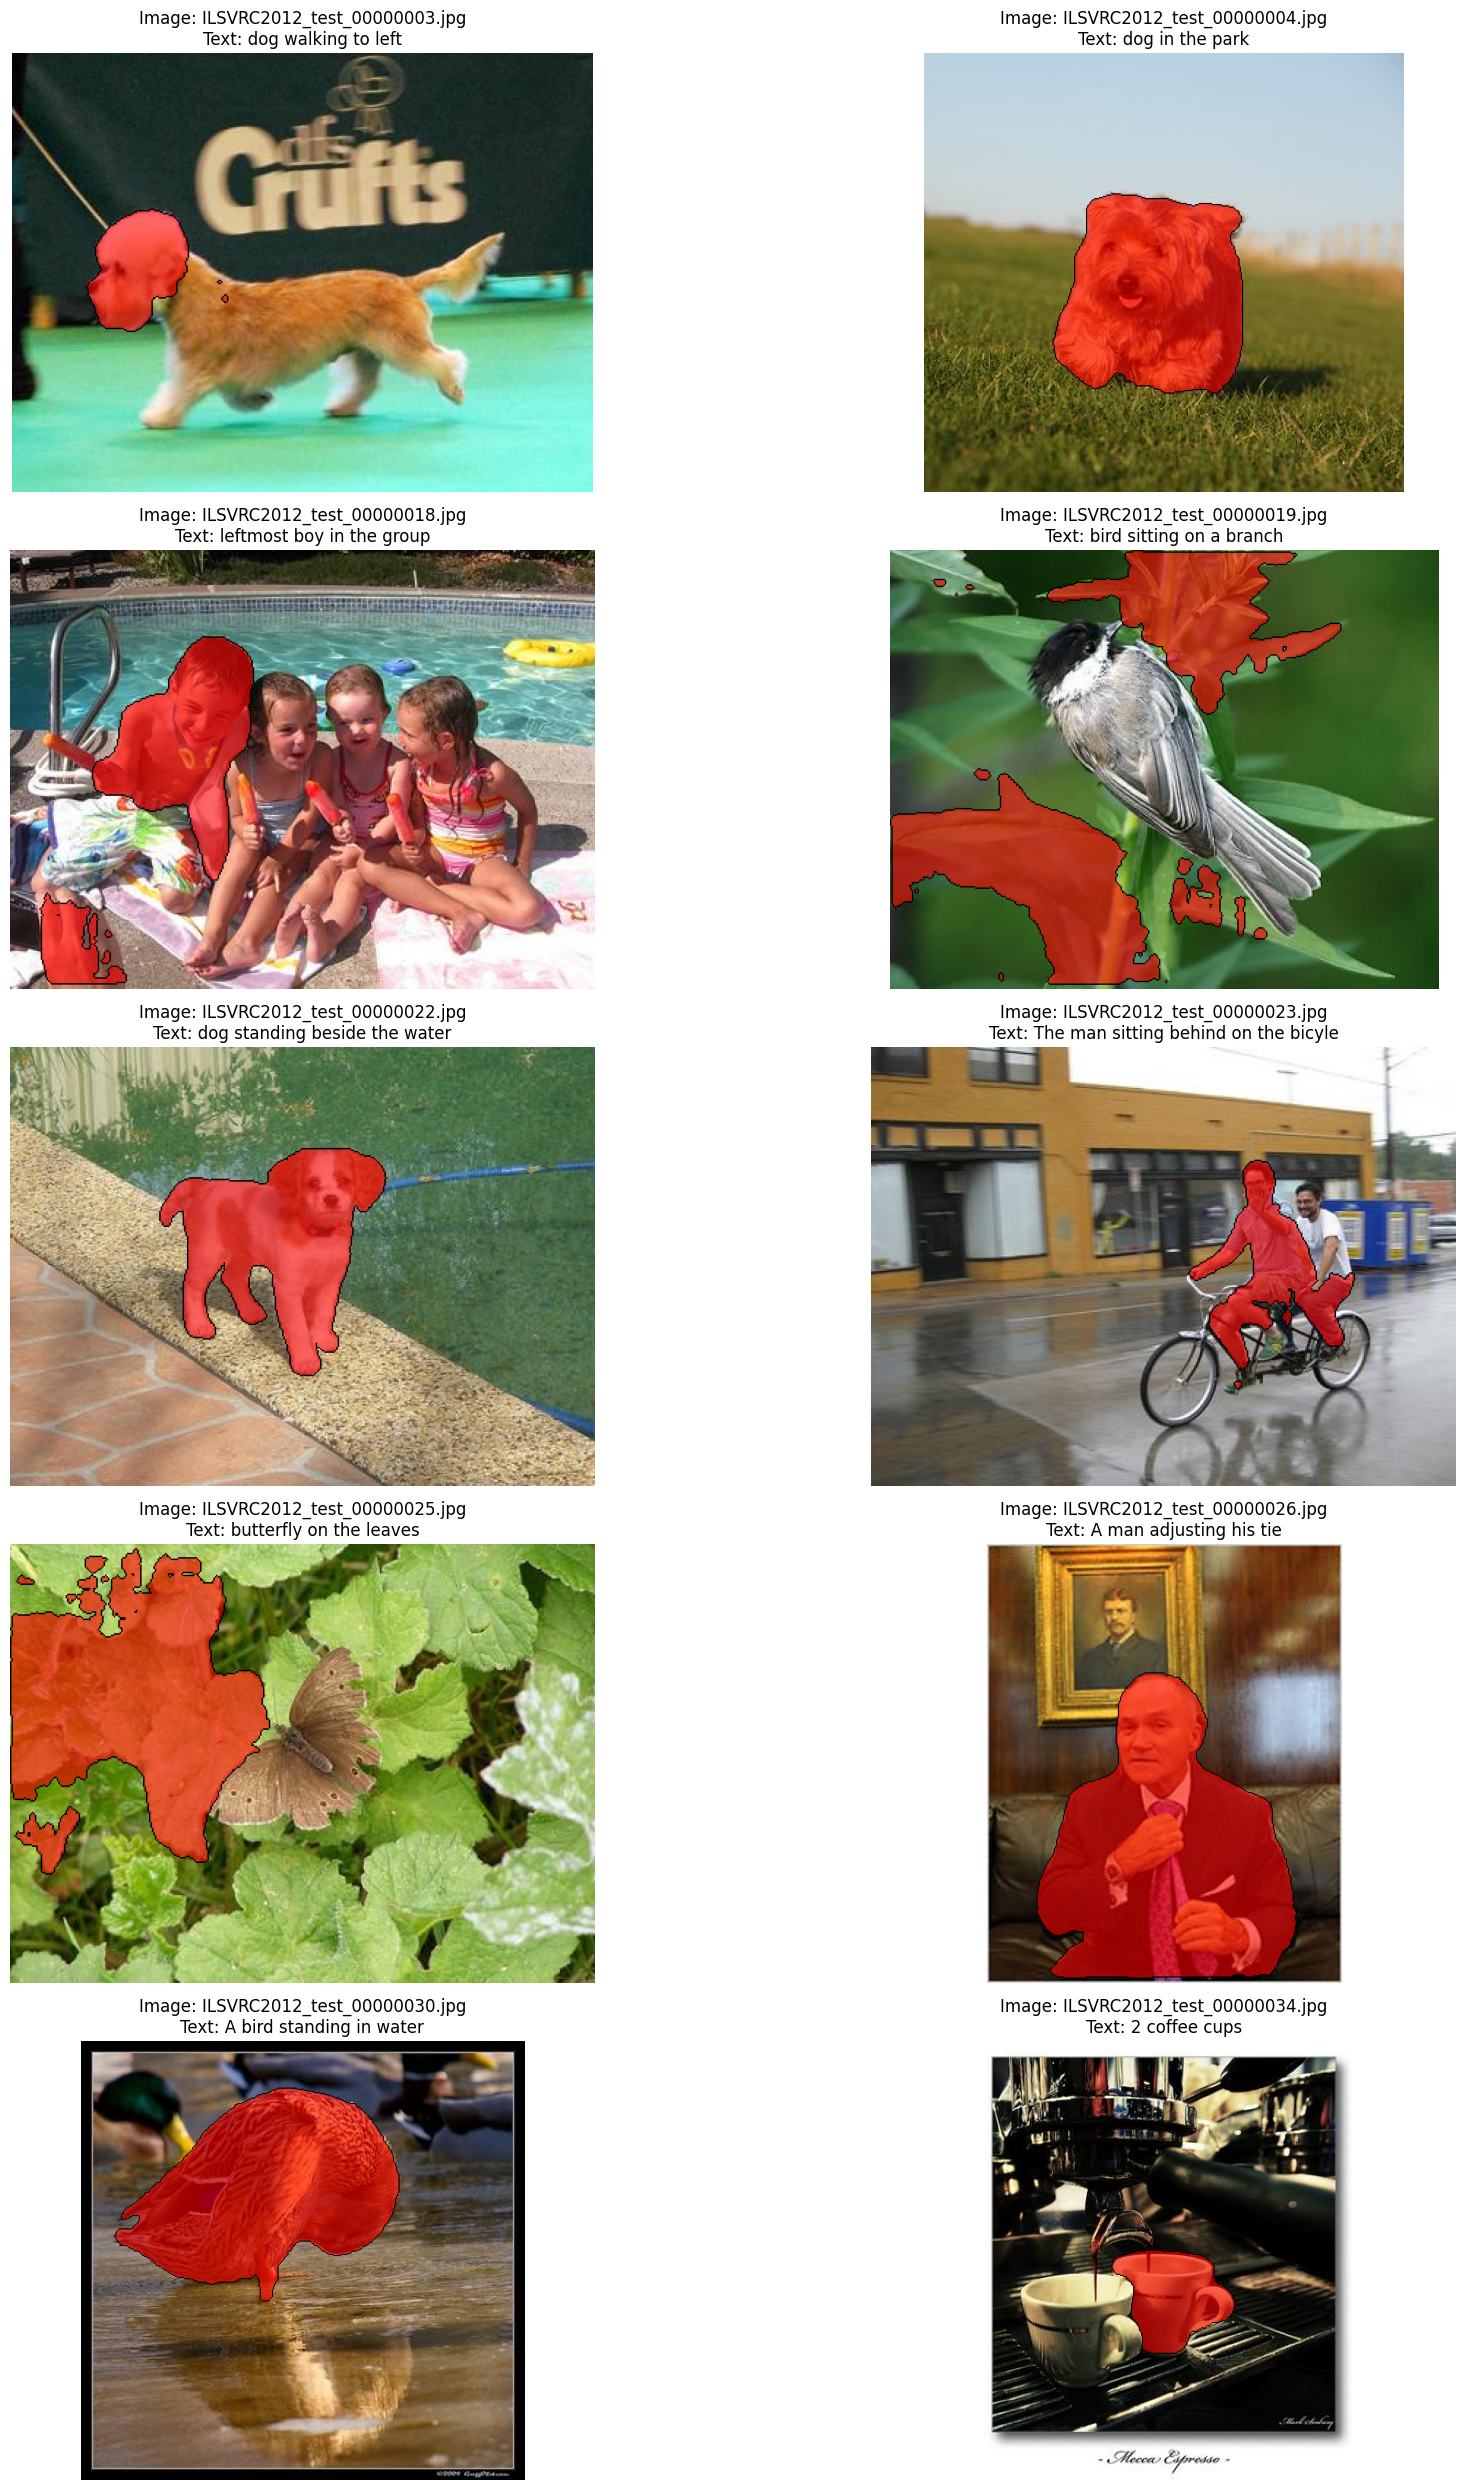

In [10]:
model_segm.to(device).eval()
bert_model.to(device).eval()

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

transform = T.Compose([
    T.Resize(480),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

def overlay_davis(image, mask, colors=[[0, 0, 0], [255, 0, 0]], cscale=1, alpha=0.4):
    colors = np.reshape(colors, (-1, 3))
    colors = np.atleast_2d(colors) * cscale

    im_overlay = image.copy()
    object_ids = np.unique(mask)

    for object_id in object_ids[1:]:
        foreground = image*alpha + np.ones(image.shape)*(1-alpha) * np.array(colors[object_id])
        binary_mask = mask == object_id

        im_overlay[binary_mask] = foreground[binary_mask]

        countours = binary_dilation(binary_mask) ^ binary_mask
        im_overlay[countours, :] = 0

    return im_overlay.astype(image.dtype)

plt.figure(figsize=(20, 25))

for idx, (image_name, text) in enumerate(images_data.items()):
    image_path = f"/kaggle/input/cv-hw3-q4/samples/{image_name}"
    
    img_pil = Image.open(image_path).convert("RGB")
    orig_w, orig_h = img_pil.size
    img_np = np.array(img_pil)
    
    img_tensor = transform(img_pil).unsqueeze(0).to(device)  
    
    tokens = tokenizer.encode(text, add_special_tokens=True)[:20]
    padded_sent_toks = [0] * 20
    padded_sent_toks[:len(tokens)] = tokens
    
    attention_mask = [0] * 20
    attention_mask[:len(tokens)] = [1] * len(tokens)
    
    input_ids = torch.tensor(padded_sent_toks).unsqueeze(0).to(device)  
    attn_mask = torch.tensor(attention_mask).unsqueeze(0).to(device)  
    
    with torch.no_grad():
        last_states = bert_model(input_ids, attention_mask=attn_mask)[0]
        embedding = last_states.permute(0,2,1)
        output = model_segm(img_tensor, embedding, l_mask=attn_mask.unsqueeze(2))
        output = output.argmax(dim=1, keepdim=True).float()
        output = F.interpolate(output, (orig_h, orig_w), mode="nearest").squeeze().cpu().numpy()
    
    output = output.astype(np.uint8)
    visualization = overlay_davis(img_np, output)
    
    plt.subplot(5, 2, idx+1)
    plt.imshow(visualization)
    plt.title(f"Image: {image_name}\nText: {text}")
    plt.axis('off')

plt.tight_layout()
plt.show()